In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_excel("INPUT SET 3.xlsx")

In [3]:
# splitting the remaining data in training data and validation data. 
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, shuffle = False)

In [4]:
df_train.index = range(df_train.shape[0])
df_test.index = range(df_test.shape[0])

In [5]:
# Scaling the data using MinMax Scaler.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(df_train.drop(["Y"],axis=1).values)
Y_train = scaler.fit_transform(df_train["Y"].values.reshape(-1,1))
X_test = scaler.fit_transform(df_test.drop(["Y"],axis=1).values)
Y_test = scaler.fit_transform(df_test["Y"].values.reshape(-1,1))

In [6]:
# function to denormalize the obtained output.
def denormalize(df,norm_data):
    df = df["Y"].values.reshape(-1,1)
    norm_data = norm_data.reshape(-1,1)
    scl = MinMaxScaler()
    a = scl.fit_transform(df)
    new = scl.inverse_transform(norm_data)
    
    return new

In [7]:
#-----------------------------------------------------------------------------------------------------
# SVR using kernel definition.

In [8]:
# defining variables and parameters used for model definition and training.
batch_size = 50
epochs = 100
x_data = tf.placeholder(shape=[None, 4], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_data = tf.placeholder(shape=[None, 4], dtype=tf.float32)
b = tf.Variable(tf.zeros(shape=[1,batch_size]))

In [9]:
indices = np.random.choice(len(X_train), batch_size)

In [10]:
# kernel definition.(linear, polynomial, RBF)

def kernel(kernel_name):
    if(kernel_name == "rbf"):
        gamma = tf.constant(-1.)
        # rA = X_data^2 having shape = [batch_size,1]
        rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1]) 
        # rB = prediction_data^2 having shape = [prediction_sample,1]
        rB = tf.reshape(tf.reduce_sum(tf.square(prediction_data), 1),[-1,1])
        # pred_sq_list gives the square distance between prediction_data and every other X_data's samples.
        # pred_sq_list = X^2 - 2.X.Xi + Xi^2
        pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data,tf.transpose(prediction_data)))), tf.transpose(rB))
        #pred_kernel = exp(-gamma*(||X-Xi||**2))
        pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist))) 
        
    elif(kernel_name == "poly"):
        degree = tf.constant(2.0)
        # pred_kernel = (1+X.Xi)**2
        pred_kernel = (tf.add(1.0, tf.matmul(x_data,tf.transpose(prediction_data))))**degree
        
    else:
        #pred_kernel = X.Xi
        pred_kernel = tf.matmul(x_data,tf.transpose(prediction_data))
        
    return pred_kernel        

In [11]:
my_kernel = kernel("linear")

In [12]:
# output hyperplane 
y_predicted = tf.matmul(b, my_kernel)

In [13]:
# definition for the loss function.
epsilon = tf.constant([0.08])
# b_vec_cross = bi.bj having shape [batch_size, batch_size]
b_vec_cross = tf.matmul(tf.transpose(b),b)
#first_term = summation of 1/2*bi.bj*k(xi,xj)
first_term = tf.reduce_sum(tf.multiply(0.5,tf.multiply(b_vec_cross, my_kernel)))
# second_term = summation of |bi|*epsilon
second_term = tf.multiply(epsilon,tf.reduce_sum(tf.abs(b)))
# third_term = summation of bi.yi
third_term = tf.matmul(b, y_target)
#loss = first_term + second_term - third_term
loss = tf.subtract(tf.add(first_term, second_term), third_term)

In [14]:
train = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

In [15]:
train_loss = []
test_loss = [] 

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# loop for training SVR model.

for i in range(epochs):
        
    train_indices = np.random.choice(len(X_train), batch_size)
    x_train = X_train[train_indices]
    y_train = Y_train[train_indices]
    test_indices = np.random.choice(len(X_test), batch_size)
    x_test = X_test[test_indices]
    y_test = Y_test[test_indices]
    
    for j in range(x_train.shape[0]):
        sess.run(train,feed_dict={x_data:x_train, y_target:y_train, prediction_data:x_train[j,:].reshape(1,4)})
    
    train_loss.append(sess.run(loss,feed_dict={x_data:x_train, y_target:y_train, prediction_data:x_train}))
    test_loss.append(sess.run(loss, feed_dict={x_data:x_test, y_target:y_test, prediction_data:x_test}))
    print('Epoch :',i,'Training Cost :',train_loss[i])
        
# end of for loop for training the model. 

Epoch : 0 Training Cost : [[-0.16552609]]
Epoch : 1 Training Cost : [[-0.261199]]
Epoch : 2 Training Cost : [[-0.05140013]]
Epoch : 3 Training Cost : [[-0.10053802]]
Epoch : 4 Training Cost : [[0.00129074]]
Epoch : 5 Training Cost : [[0.49950492]]
Epoch : 6 Training Cost : [[-0.05621147]]
Epoch : 7 Training Cost : [[-0.18224645]]
Epoch : 8 Training Cost : [[0.38253266]]
Epoch : 9 Training Cost : [[0.0462231]]
Epoch : 10 Training Cost : [[0.00833687]]
Epoch : 11 Training Cost : [[-0.16081053]]
Epoch : 12 Training Cost : [[0.04602879]]
Epoch : 13 Training Cost : [[-0.11557594]]
Epoch : 14 Training Cost : [[-0.00200626]]
Epoch : 15 Training Cost : [[-0.16093093]]
Epoch : 16 Training Cost : [[0.03657204]]
Epoch : 17 Training Cost : [[-0.03547701]]
Epoch : 18 Training Cost : [[-0.17650044]]
Epoch : 19 Training Cost : [[-0.11200136]]
Epoch : 20 Training Cost : [[-0.15396953]]
Epoch : 21 Training Cost : [[0.13042611]]
Epoch : 22 Training Cost : [[-0.11276543]]
Epoch : 23 Training Cost : [[-0.

In [17]:
x = X_train[indices]
# predicting ouput for X_test.
pred = sess.run(y_predicted, feed_dict={x_data:x, prediction_data:X_test})

In [18]:
# denormalizing Y_test and corresponding predicted output.
y_test = denormalize(df_test, Y_test)
pred = denormalize(df_test, pred)

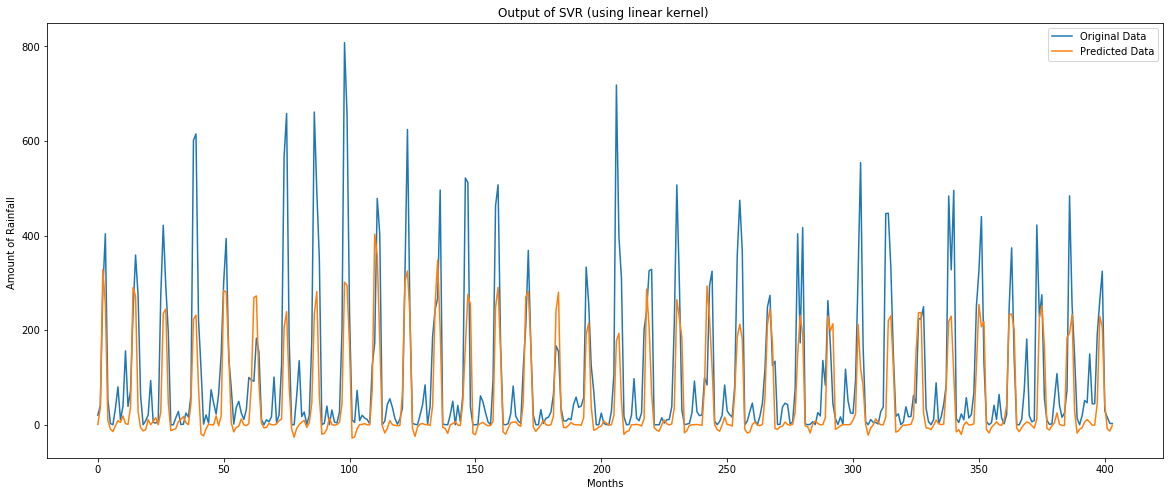

In [19]:
# plot showing difference between actual test data and predicted test data.
plt.figure(figsize=[20,8])
plt.plot(range(y_test.shape[0]),y_test,label="Original Data")
plt.plot(range(y_test.shape[0]),pred,label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('Amount of Rainfall ')
plt.xlabel('Months')
plt.title('Output of SVR (using linear kernel) ')
plt.show()

In [20]:
# Mean absolute Error.
print("MAE : ", np.mean(abs(y_test-pred)))

MAE :  65.17883929502597


In [21]:
print("RMSE : ", np.sqrt(np.mean(np.square(y_test-pred))))

RMSE :  111.9594449953607
